In [3]:
import requests
import gzip

import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '/cellar/users/mikeyu/DeepTranslate/ddot')

np.set_printoptions(precision=3)

import ddot
from ddot import Ontology, get_gene_name_converter, parse_gaf, parse_obo, nx_to_NdexGraph, read_term_descriptions, ndex_to_sim_matrix
from ddot import expand_seed, melt_square, make_index, align_hierarchies, update_nx_with_alignment, parse_ndex_uuid, NdexGraph_to_nx, bubble_layout_nx, ddot_pipeline

# Setup parameters

In [4]:
alpha = 0.1
beta = 0.5

In [5]:
seed = ['FANCA','FANCB', 'FANCC', 'BRCA2', 'FANCD2', 'FANCE',
        'FANCF', 'FANCG', 'FANCI', 'BRIP1', 'FANCL', 'FANCM', 'PALB2', 'RAD51C', 'SLX4', 'ERCC4', 'RAD51',
        'BRCA1', 'UBE2T', 'XRCC2']

In [6]:
ndex_user = 'mikeyu_testacct3'
ndex_pass = 'GoHejVeg8'
ndex_server = 'http://test.ndexbio.org'

# Download GO from NDEx

In [7]:
# go_human = Ontology.from_ndex(ddot.config.GO_HUMAN_URL)
# print go_human.summary()

In [8]:
# go_human.to_pickle('/cellar/users/mikeyu/go.pkl')
# go_human = Ontology.read_pickle('/cellar/users/mikeyu/go.pkl')

In [9]:
go_human = Ontology.from_table('/cellar/users/mikeyu/DeepTranslate/go_human_10aug2017/collapsed_go.symbol', clixo_format=True)
# go_human_entrez = Ontology.from_table('/cellar/users/mikeyu/DeepTranslate/go_human_10aug2017/collapsed_go.entrez', clixo_format=True)

# Download gene similarity network from NDEx

In [10]:
# sim, sim_names = ndex_to_sim_matrix(
#     ndex_uuid='d2dfa5cc-56de-11e7-a2e2-0660b7976219',
#     similarity='similarity',
#     input_fmt='cx_matrix',
#     output_fmt='matrix',
#     subset=None)

In [11]:
%time tmp = np.load('/cellar/users/mikeyu/DeepTranslate/hnexo/RFv2r3_square.npz')
rf, rf_genes = tmp['rf'], tmp['genes']
np.fill_diagonal(rf, 0)
rf[np.isnan(rf)] = 0
sim, sim_names = rf, rf_genes

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.09 ms


In [12]:
# Rank the similarity scores
sim_rank = pd.DataFrame(sim).rank(0) / (sim.shape[0] - 1)
sim_rank = pd.DataFrame((sim_rank.values + sim_rank.values.T) / 2.0)

# Download gene-drug targets

In [13]:
# pharos, pharos_nodes = ndex_to_sim_matrix(
#     parse_ndex_uuid(ddot.config.PHAROS_URL),
#     similarity=None,
#     input_fmt='cx',
#     output_fmt='sparse')
# pharos.rename(columns={'Node1' : 'gene', 'Node2' : 'drug'}, inplace=True)
# gene_drug = pharos.groupby('gene').agg({'drug' : lambda x : ','.join(x)})
# gene_drug['has_drug'] = True

In [14]:
pharos = pd.read_table('/cellar/users/mikeyu/DeepTranslate/pharos/tcrd460_gene_drug.txt')
pharos.drop_duplicates(inplace=True)
gene_drug = pharos.groupby('gene').agg({'drug' : lambda x : ','.join(x)})
gene_drug['has_drug'] = True

# Run Ontology pipeline

In [18]:
ont, url, ont_ndexgraph = ddot_pipeline(
      alpha,
      beta,
      sim,
      sim_names,
      seed,
      go_human,
      node_attr=gene_drug,
      name='Fanconi Anemia Gene Ontology (FanGO)',
      expand_kwargs={'seed_perc':0, 'agg':'mean', 'figure':False},
      ndex_kwargs={'ndex_user':ndex_user, 'ndex_pass':ndex_pass, 'ndex_server':ndex_server},
      align_kwargs={'iterations':100, 'threads': 40},
      verbose=True,
)
print url

# Save to graphml
nx.write_graphml(ont_ndexgraph, '/cellar/users/mikeyu/DeepTranslate/fango/fango.graphml')

# Pickle ontology file
ont.to_pickle('/cellar/users/mikeyu/DeepTranslate/fango/fango.pkl')

# Save NDEx URL
with open('/cellar/users/mikeyu/DeepTranslate/fango/fango.ndex_url.txt', 'w') as f:
    f.write(url + '\n')

min_sim: 5.20081410586
Expanded gene set: 246
temp output: /tmp/tmpZ3s_e2
temp graph: /tmp/tmpglTeun
temp output log: /tmp/tmpmNASr4
/tmp/tmpglTeun	0.1	0.5	-10000000 2017-08-31 23:06:36.229469
CLIXO command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/mhk7-clixo_0.3-cec3674/clixo /tmp/tmpglTeun 0.1 0.5 | awk '{if ( $1 ~ /^#/ ) {print "\#", strftime("%Y-%m-%d %H:%M:%S"), $0 ; fflush() } else {print $0}}' | tee /tmp/tmpmNASr4
Extracting by grep -v # 2017-08-31 23:06:37.555122
Elapsed time (sec): 1.33150100708 2017-08-31 23:06:37.592654
Ontology: 246 genes, 38 terms, 290 gene-term relations, 38 term-term relations
node_attributes: 
edge_attributes: CLIXO_score
collapse command: /cellar/users/mikeyu/alignOntology/collapseRedundantNodes /tmp/tmpcg9dRN
collapse command: /cellar/users/mikeyu/alignOntology/collapseRedundantNodes /tmp/tmp5q7N9y
Alignment command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/alignOntology/calculateFDRs /tmp/tmpyxdG2o /tmp/tmpUVio8S 0.05 criss_cross /tmp/tmppKdk

# Analysis

min_sim: 5.20081410586
Expanded gene set: 246
temp output: /tmp/tmpiSgf7P
temp graph: /tmp/tmpp4afdk
temp output log: /tmp/tmpB1T8fh
/tmp/tmpp4afdk	0.1	0.5	-10000000 2017-09-25 09:49:16.770978
CLIXO command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/mhk7-clixo_0.3-cec3674/clixo /tmp/tmpp4afdk 0.1 0.5 | awk '{if ( $1 ~ /^#/ ) {print "\#", strftime("%Y-%m-%d %H:%M:%S"), $0 ; fflush() } else {print $0}}' | tee /tmp/tmpB1T8fh
Extracting by grep -v # 2017-09-25 09:49:17.862214
Elapsed time (sec): 1.09697294235 2017-09-25 09:49:17.883452
Ontology: 246 genes, 38 terms, 290 gene-term relations, 38 term-term relations
node_attributes: 
edge_attributes: CLIXO_score
collapse command: /cellar/users/mikeyu/alignOntology/collapseRedundantNodes /tmp/tmphRyC9j
collapse command: /cellar/users/mikeyu/alignOntology/collapseRedundantNodes /tmp/tmpB7jnU4
Alignment command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/alignOntology/calculateFDRs /tmp/tmpuSfuB7 /tmp/tmp6WxU2r 0.05 criss_cross /tmp/tmpoKLU

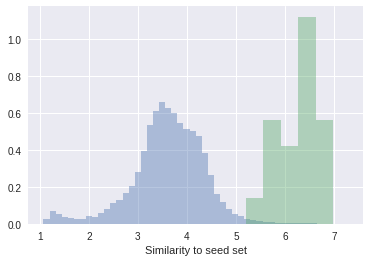

In [15]:
ont, url, ont_ndexgraph, expand_results = ddot_pipeline(
      alpha,
      beta,
      sim,
      sim_names,
      seed,
      go_human,
      node_attr=gene_drug,
      name='Fanconi Anemia Gene Ontology (FanGO)',
      expand_kwargs={'seed_perc':0, 'agg':'mean', 'figure':True},
      ndex_kwargs={'ndex_user':ndex_user, 'ndex_pass':ndex_pass, 'ndex_server':ndex_server},
      align_kwargs={'iterations':100, 'threads': 40},
      verbose=True,
      ndex=False
)

## Expand based on ranked similarities

In [ ]:
ont, url, ont_ndexgraph, expand_rank_results = ddot.utils.ddot_pipeline(
      0.05,
      beta,
      sim,
      sim_names,
      seed,
      go_human,
      node_attr=gene_drug,
      name='Fanconi Anemia Gene Ontology (FanGO)',
      expand_kwargs={'sim': sim_rank.values, 'sim_names': sim_names, 'seed_perc':0, 'agg':'mean', 'figure':True},
      ndex_kwargs={'ndex_user':'scratch', 'ndex_pass':'scratch', 'ndex_server':ndex_server},
      align_kwargs={'iterations':2, 'threads': 3},
      verbose=True,
      ndex=True
)

print url

basename = 'fango.rank.a_0.05'

# Save to graphml
nx.write_graphml(ont_ndexgraph, '/cellar/users/mikeyu/DeepTranslate/fango/%s.graphml' % basename)

# # Pickle ontology file
# ont.to_pickle('/cellar/users/mikeyu/DeepTranslate/fango/%s.pkl' % basename)

# # Save NDEx URL
# with open('/cellar/users/mikeyu/DeepTranslate/fango/fango.ndex_url.txt', 'w') as f:
#     f.write(url + '\n')

expand_kwargs keys: ['agg', 'sim_names', 'figure', 'sim', 'seed_perc']
expand_kwargs keys: ['agg', 'sim_names', 'figure', 'sim', 'seed_perc']
min_sim: 0.840498737374
Expanded gene set: 429
temp output: /tmp/tmpnabGj0
temp graph: /tmp/tmpP8LDRd
temp output log: /tmp/tmpGIIGJk
/tmp/tmpP8LDRd	0.05	0.5	-10000000 2017-09-25 10:56:21.812846
CLIXO command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/mhk7-clixo_0.3-cec3674/clixo /tmp/tmpP8LDRd 0.05 0.5 | awk '{if ( $1 ~ /^#/ ) {print "\#", strftime("%Y-%m-%d %H:%M:%S"), $0 ; fflush() } else {print $0}}' | tee /tmp/tmpGIIGJk
Extracting by grep -v # 2017-09-25 10:56:23.789202
Elapsed time (sec): 1.97818112373 2017-09-25 10:56:23.806455
Ontology: 429 genes, 146 terms, 876 gene-term relations, 173 term-term relations
node_attributes: 
edge_attributes: CLIXO_score
collapse command: /cellar/users/mikeyu/alignOntology/collapseRedundantNodes /tmp/tmpmu5J1C
collapse command: /cellar/users/mikeyu/alignOntology/collapseRedundantNodes /tmp/tmp1crHOc
Alig

In [16]:
basename = 'fango.rank.a_0.05'

# Save to graphml
nx.write_graphml(ont_ndexgraph, '/cellar/users/mikeyu/DeepTranslate/fango/%s.graphml' % basename)

AttributeError: 'NoneType' object has no attribute 'is_directed'

## Analyze drugs (doramapimod, danazol, tremulacin, resveratrol) in 

Modelling Fanconi anemia pathogenesis and therapeutics using integration-free patient-derived iPSCs

Guang-Hui Liu, Keiichiro Suzuki[…]Juan Carlos Izpisua Belmonte

Nat Comm 2014

https://www.nature.com/articles/ncomms5330

In [59]:
sim_names_2_index = ddot.make_index(sim_names)
doramapimod_targets = ['MAPK14']

# for g in ['MAPK14', 'SIRT1']:
print '--------------\nDORAMAPIMOD\n----------------'
for g in doramapimod_targets:
    print g, expand_results['sim_2_seed'][sim_names_2_index[g]]
print '--------------\nDANAZOL\n--------------------'
for g in danazol_targets:
    if sim_names_2_index.has_key(g):
        print g, expand_results['sim_2_seed'][sim_names_2_index[g]]
    else:
        print g, None
print '--------------\nRESVERATROL\n--------------------'
for prot in resveratrol_targets:
    g = uniprot_2_symbol[prot]
    print g, expand_results['sim_2_seed'][sim_names_2_index[g]]    

--------------
DORAMAPIMOD
----------------
MAPK14 4.7347316969
--------------
DANAZOL
--------------------
ESR1 4.18767324569
AR 4.24415533601
PGR 3.95895529765
GNRHR 3.71385777327
GNRHR2 None
CCL2 4.05967928262
--------------
RESVERATROL
--------------------
NQO2 4.05970725904
CSNK2A1 4.47084835889
PTGS1 4.27848051557
PTGS2 4.03183188885
ALOX15 3.50135926612
ALOX5 4.540854534
AHR 4.32784587545
PI4K2B 3.76117958109
ITGA5 4.08251866356
ITGB3 4.20139344358
APP 4.65135539059
SNCA 4.22859744509
ESR1 4.18767324569
MTNR1A 3.10433967927
MTNR1B 3.77106802382
CLEC14A 2.67376263885
NR1I2 3.94983589403
NR1I3 3.22243732039
SLC2A1 4.46799776057
CBR1 4.08947881991
PPARA 3.94621490134
PPARG 3.7372701393
AKT1 4.4181894815
KHSRP 4.98514756052
YARS 4.48174374576


In [55]:
danazol_uniprot = '''P03372
P10275
P06401
P30968
Q96P88
P13500'''.splitlines()
tmp = get_gene_name_converter(danazol_uniprot, scopes='uniprot', fields='symbol', species='human')
tmp['Q96P88'] = 'GNRHR2' # from https://www.phosphosite.org/proteinAction?id=6648&showAllSites=true
danazol_targets = [tmp[x] for x in danazol_uniprot]
danazol_targets

[u'ESR1', u'AR', u'PGR', u'GNRHR', 'GNRHR2', u'CCL2']

In [52]:
resveratrol_uniprot = '''P16083
P68400
P23219
P35354
P16050
P09917
P35869
Q8TCG2
P08648
P05106
P05067
P37840
P03372
P48039
P49286
Q86T13
O75469
Q14994
P11166
P16152
Q07869
P37231
P31749
Q92945
P54577'''.splitlines()
tmp = get_gene_name_converter(resveratrol_uniprot, scopes='uniprot', fields='symbol', species='human')
reveratrol_targets = [tmp[x] for x in resveratrol_uniprot]

In [14]:
# Genes in fango with drugs
gene_drug.loc[ont.genes].dropna()

,drug,has_drug
gene,,
AURKB,axitinib,True
DNMT1,"azacitidine,decitabine",True
MELK,nintedanib,True
PARP1,"rucaparib,olaparib,niraparib",True
PARP2,"rucaparib,olaparib,niraparib",True
PLK4,axitinib,True
POLA1,"cytarabine,clofarabine,fludarabine phosphate,g...",True
POLD1,"cytarabine,gemcitabine",True
PPAT,mercaptopurine,True


## Analysis of autophagy paper
Sumpter 2016 Cell
http://www.sciencedirect.com/science/article/pii/S009286741630397X?via%3Dihub

Review of selective autophagy processes by Jean Claude and Subramani
https://www.nature.com/nrm/journal/v17/n9/fig_tab/nrm.2016.74_T2.html

In [108]:
go_human.propagate_annotations(inplace=True)

<ddot.Ontology.Ontology instance at 0x7fdd2d97f320>

In [ ]:
sim_df = pd.DataFrame(sim, columns=sim_names, index=sim_names)

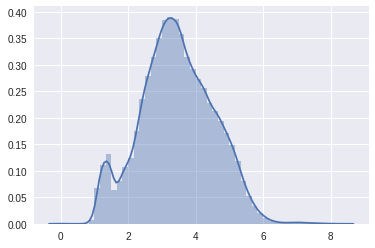

In [104]:
sim_flat = sim[np.triu_indices(sim.shape[0], k=1)]
sns.distplot(np.random.choice(sim_flat, 100000))

### Autophagy term

Autophagy genes: 470


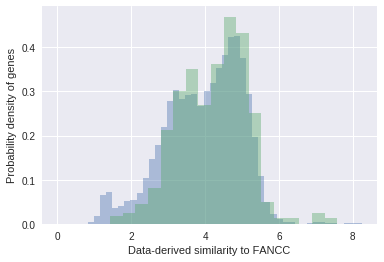

In [167]:
# Autophagy term
print 'Autophagy genes:', len([go_human.genes[g] for g in go_human.term_2_gene['GO:0006914']])
fig = plt.figure(figsize=(6, 4))
ax = sns.distplot(sim_df['FANCC'], kde=False, norm_hist=True)
ax = sns.distplot(sim_df.loc[[go_human.genes[g] for g in go_human.term_2_gene['GO:0006914']], 'FANCC'].dropna(), kde=False, norm_hist=True)
ax.set(xlabel='Data-derived similarity to FANCC', ylabel='Probability density of genes')

In [168]:
df = sim_df.loc[[go_human.genes[g] for g in go_human.term_2_gene['GO:0006914']], 'FANCC']
df[df > 6.9]

CAPN1     7.328646
HSPA8     7.572541
RPS27A    7.077502
UBA52     6.989941
UBB       6.992048
UBC       7.079985
Name: FANCC, dtype: float64

### Mitophagy term

Mitophagy genes: 88


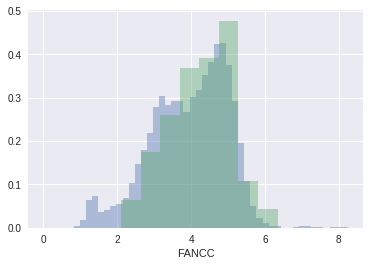

In [102]:
# Mitophagy term, GO:0000422
print 'Mitophagy genes:', len([go_human.genes[g] for g in go_human.term_2_gene['GO:0000422']])
sns.distplot(sim_df['FANCC'], kde=False, norm_hist=True)
sns.distplot(sim_df.loc[[go_human.genes[g] for g in go_human.term_2_gene['GO:0000422']], 'FANCC'].dropna(), kde=False, norm_hist=True)

           FANCC      Rank
PARK2   4.327426  0.781972
TOMM20  4.619613  0.847994
ATP5B   4.999000  0.918945
HSPD1   4.800671  0.884095
COX4I1  5.361087  0.965312


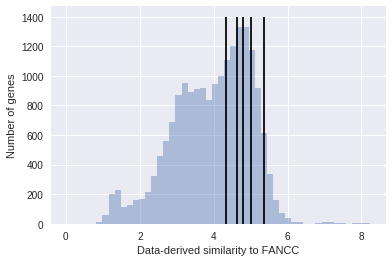

In [169]:
# PARK2 = Parkin, which mediates mitophagy
# TOMM20, ATP5B, HSP60 (aka HSPD1), COXIV (aka COX4I1)
# Mitochondria localization markers: as measured by quantitation of TOMM20 (outer mitochondrial membrane protein) and ATP5B (mitochondrial matrix protein) puncta (Figures 3A and 3B) or by western blot detection of TOMM20, HSP60 (mitochondrial matrix protein), and COXIV (inner mitochondrial membrane protein)
df = sim_df.loc[['PARK2', 'TOMM20', 'ATP5B', 'HSPD1', 'COX4I1'], ['FANCC']]
df['Rank'] = df.apply(lambda x: (x['FANCC'] > sim_flat).sum() / float(sim_flat.size), axis=1)
print df
mitophagy_df = df

fig = plt.figure(figsize=(6, 4))
ax = sns.distplot(sim_df['FANCC'], kde=False, norm_hist=False)
ax.vlines(df['FANCC'].values, 0, 1400)
ax.set(xlabel='Data-derived similarity to FANCC', ylabel='Number of genes')
# fig.savefig('/cellar/users/mikeyu/public_html/tmp.png')

In [175]:
[x in ont.genes for x in ['PARK2', 'TOMM20', 'ATP5B', 'HSPD1', 'COX4I1']]

[False, False, False, False, False]

### Xenophagy

Xenophagy genes: 10


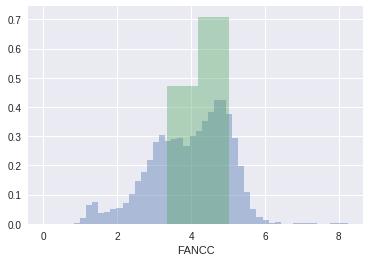

In [101]:
# Xenophagy term, GO:0098792
# Closest term to the concept of virophagy
print 'Xenophagy genes:', len([go_human.genes[g] for g in go_human.term_2_gene['GO:0098792']])
sns.distplot(sim_df['FANCC'], kde=False, norm_hist=True)
sns.distplot(sim_df.loc[[go_human.genes[g] for g in go_human.term_2_gene['GO:0098792']], 'FANCC'].dropna(), kde=False, norm_hist=True)

           FANCC
TRIM5   2.864414
SMURF1  3.968265


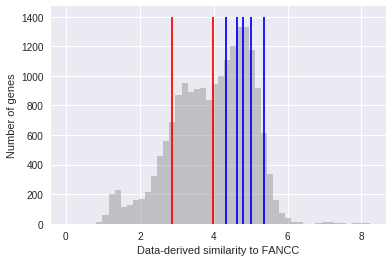

In [173]:
# from Sumppter 2016 Cell.
# p62, SMURF1 are two proteins in mediating virophagy against the virus SIN
# p62 = TRIM5
df = sim_df.loc[['TRIM5', 'SMURF1'], ['FANCC']]
print df

fig = plt.figure(figsize=(6, 4))
ax = sns.distplot(sim_df['FANCC'], kde=False, norm_hist=False, color='grey')
ax.vlines(df['FANCC'].values, 0, 1400, color='red')
ax.vlines(mitophagy_df['FANCC'].values, 0, 1400, color='blue')
ax.set(xlabel='Data-derived similarity to FANCC', ylabel='Number of genes')

## Analyze alcohol metabolism

Alcohol Dehydrogenase (ALD) and Aldehyde Dehydrogenase (ADLH) genes are reviewed in Edenberg Alcohol Res Health 2007
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3860432/

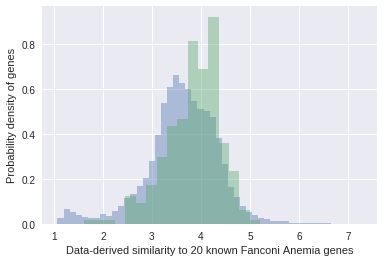

In [305]:
sim_names_2_index = ddot.make_index(sim_names)
indices = [x for x in [sim_names_2_index.get(go_human.genes[g], None) for g in go_human.term_2_gene['GO:0006066']] if x is not None]
ax = sns.distplot(expand_results['sim_2_seed'], kde=False, norm_hist=True)
ax = sns.distplot(expand_results['sim_2_seed'][indices], kde=False, norm_hist=True)
ax.set(xlabel='Data-derived similarity to 20 known Fanconi Anemia genes', ylabel='Probability density of genes')
# sns.distplot(sim_df['FANCC'], kde=False, norm_hist=True)
# sns.distplot(sim_df.loc[[go_human.genes[g] for g in go_human.term_2_gene['GO:0006066']], ['FANCC']].dropna())

In [177]:
[g for g in [go_human.genes[g] for g in go_human.term_2_gene['GO:0006066']] if g in ont.genes]

['LBR']

# Analyze RFWD3
New gene that is a E3 ubiquitin ligase

In [187]:
expand_results['sim_2_seed'][(sim_names == 'RFWD3').nonzero()[0][0]]

4.9358252716196418

In [258]:
df = pd.DataFrame(index=seed)
sim_names_2_index = ddot.make_index(sim_names)
fa_idx = [sim_names_2_index[s] for s in seed]
for g in seed:
    g_idx = sim_names_2_index[g]
    g_sim = sim[g_idx, fa_idx]
    g_perc = (sim[:, fa_idx] < g_sim.reshape(1, -1)).sum(0) / float(sim.shape[0] - 1)
    df['%s_sim' % g] = g_sim
    df['%s_sim_perc' % g] = g_perc
df = df.T
df

,FANCA,FANCB,FANCC,BRCA2,FANCD2,FANCE,FANCF,FANCG,FANCI,BRIP1,FANCL,FANCM,PALB2,RAD51C,SLX4,ERCC4,RAD51,BRCA1,UBE2T,XRCC2
FANCA_sim,0.000000,7.665104,8.127575,6.414759,7.131968,8.107625,8.133525,8.114880,7.623168,7.191518,7.915455,7.686853,4.919861,5.698090,7.281170,7.449128,6.185612,8.123561,7.017165,6.287984
FANCA_sim_perc,0.000000,0.999579,0.999842,0.992161,0.996317,0.999842,0.999895,0.999947,0.999790,0.998948,0.999737,0.999000,0.982271,0.965173,0.997685,0.998737,0.986164,0.997685,0.997843,0.996423
FANCB_sim,7.665104,0.000000,6.771049,4.947805,7.430605,7.123895,7.137596,7.876083,7.144021,4.253695,7.666925,7.754939,3.136707,3.893176,7.336919,6.774013,3.752006,4.290523,7.382528,4.289215
FANCB_sim_perc,0.998632,0.000000,0.997317,0.698074,0.998053,0.998790,0.999053,0.999263,0.998895,0.948232,0.999211,0.999211,0.359322,0.348537,0.997843,0.993003,0.406776,0.560080,0.999579,0.619844
FANCC_sim,8.127575,6.771049,0.000000,5.818381,7.227028,8.128179,8.161589,8.102749,7.298342,4.269397,7.853620,7.912879,3.662798,5.330723,7.442037,7.408429,5.715941,5.707332,7.008214,5.308710
FANCC_sim_perc,0.999790,0.998106,0.000000,0.965488,0.997054,0.999947,0.999947,0.999842,0.999474,0.949074,0.999579,0.999632,0.693497,0.870160,0.998580,0.998527,0.963910,0.952073,0.997790,0.930345
BRCA2_sim,6.414759,4.947805,5.818381,0.000000,7.830819,7.453912,5.020994,7.957709,5.682074,7.109639,5.335388,4.911664,8.000441,7.114549,7.431057,5.584397,8.135328,8.145746,5.262312,7.306519
BRCA2_sim_perc,0.993424,0.987532,0.991267,0.000000,0.999263,0.999421,0.975957,0.999579,0.979272,0.998527,0.985743,0.974274,0.999737,0.998369,0.998527,0.975011,0.999579,0.998159,0.954861,0.998948
FANCD2_sim,7.131968,7.430605,7.227028,7.830819,0.000000,7.801961,7.213720,7.309339,7.933257,5.663237,7.870917,7.402274,4.658996,7.310319,7.581861,7.053115,7.872530,7.837479,7.123080,7.435635
FANCD2_sim_perc,0.997106,0.999474,0.998474,0.998737,0.000000,0.999579,0.999211,0.998843,0.999842,0.990688,0.999684,0.998474,0.970013,0.999000,0.999053,0.994003,0.998527,0.992950,0.998316,0.999158


In [259]:
df.loc[[x for x in df.index if 'perc' in x], :].mean(1)

FANCA_sim_perc     0.945352
FANCB_sim_perc     0.795986
FANCC_sim_perc     0.915641
BRCA2_sim_perc     0.940372
FANCD2_sim_perc    0.946557
FANCE_sim_perc     0.900639
FANCF_sim_perc     0.843503
FANCG_sim_perc     0.943942
FANCI_sim_perc     0.943411
BRIP1_sim_perc     0.893269
FANCL_sim_perc     0.909267
FANCM_sim_perc     0.882949
PALB2_sim_perc     0.808481
RAD51C_sim_perc    0.922861
SLX4_sim_perc      0.931416
ERCC4_sim_perc     0.886698
RAD51_sim_perc     0.934812
BRCA1_sim_perc     0.941172
UBE2T_sim_perc     0.868032
XRCC2_sim_perc     0.891467
dtype: float64

In [280]:
g = 'FANCB'
g_idx = sim_names_2_index[g]
g_sim = sim[g_idx, fa_idx]
g_perc = (sim[:, fa_idx] < g_sim.reshape(1, -1)).sum(0) / float(sim.shape[0] - 1)
print g_perc

print g_sim
print sim_argsort[g_idx, fa_idx]

[ 0.999  0.     0.997  0.698  0.998  0.999  0.999  0.999  0.999  0.948
  0.999  0.999  0.359  0.349  0.998  0.993  0.407  0.56   1.     0.62 ]
[ 7.665  0.     6.771  4.948  7.431  7.124  7.138  7.876  7.144  4.254
  7.667  7.755  3.137  3.893  7.337  6.774  3.752  4.291  7.383  4.289]
[ 2550  9211  4300  2563   604 11744  5811  7451  1500 10842 16889  7900
 18897  1131  6444  8917 18947  8226  7270 17664]


In [289]:
# x = np.random.random(5)
print x
tmp = np.argsort(x)
print tmp
tmp2 = np.empty(x.size, np.int32)
tmp2[tmp] = np.arange(x.size)
print tmp2

[ 0.958  0.429  0.047  0.487  0.331]
[2 4 1 3 0]
[4 2 0 3 1]


In [295]:
# df = pd.DataFrame(np.random.random((5,5)))
df.loc[0,:] = df.loc[1,:]
print df
df.rank(0, method='min')

          0         1         2         3         4
0  0.196273  0.692368  0.284013  0.124768  0.273781
1  0.196273  0.692368  0.284013  0.124768  0.273781
2  0.500318  0.109638  0.032496  0.816772  0.717121
3  0.580478  0.250494  0.610363  0.508620  0.523114
4  0.802217  0.876236  0.199837  0.423788  0.965456


,0,1,2,3,4
0,1.0,3.0,3.0,1.0,1.0
1,1.0,3.0,3.0,1.0,1.0
2,3.0,1.0,1.0,5.0,4.0
3,4.0,2.0,5.0,4.0,3.0
4,5.0,5.0,2.0,3.0,5.0


In [285]:
print fa_idx[-1]
print sim[g_idx, 18161]
print np.argsort(sim[:, 18161])[g_idx]
print (sim[g_idx, 18161] < sim[:, 18161]).sum()

18161
4.28921511819
17664
7226


In [314]:
sim_rank = pd.DataFrame(sim).rank(0) / (sim.shape[0] - 1)
sim_rank = pd.DataFrame((sim_rank.values + sim_rank.values.T) / 2.0)

min_sim: 0.840498737374


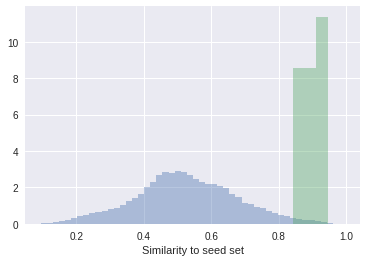

In [324]:
a, b, c, fig_tmp = expand_seed(seed, sim_rank.values, sim_names, agg='mean', seed_perc=0, figure=True)
fig_tmp

In [344]:
Ontology.run_clixo(melt_square(pd.DataFrame(sim[b, :][:, b], columns=a, index=a)),
                   0.05, 0.5)

temp output: /tmp/tmpTGeU0C
temp graph: /tmp/tmpbGyTQH
temp output log: /tmp/tmp6a6ZS4
/tmp/tmpbGyTQH	0.05	0.5	-10000000 2017-09-25 09:21:38.025429
CLIXO command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/mhk7-clixo_0.3-cec3674/clixo /tmp/tmpbGyTQH 0.05 0.5 | awk '{if ( $1 ~ /^#/ ) {print "\#", strftime("%Y-%m-%d %H:%M:%S"), $0 ; fflush() } else {print $0}}' | tee /tmp/tmp6a6ZS4
Extracting by grep -v # 2017-09-25 09:21:39.936868
Elapsed time (sec): 1.91143894196 2017-09-25 09:21:39.967189
Ontology: 429 genes, 146 terms, 876 gene-term relations, 173 term-term relations
node_attributes: 
edge_attributes: CLIXO_score


<ddot.Ontology.Ontology instance at 0x7fdd290a5ea8>

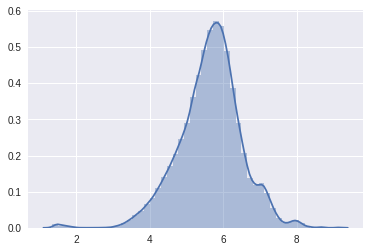

In [343]:
sns.distplot(sim[b, :][:, b][np.triu_indices(b.size,1)])

In [320]:
'RFWD3' in a

True

min_sim: 5.20081410586


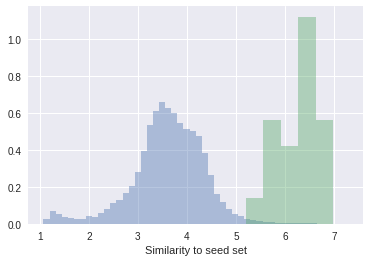

In [219]:
a, b, c, fig_tmp = expand_seed(seed, sim, sim_names, agg='mean', seed_perc=0, figure=True)
fig_tmp

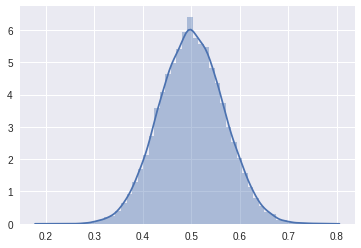

In [239]:
sns.distplot(sim_rank[fa_idx, :].mean(0))

In [257]:
pd.DataFrame(sim_rank[fa_idx, :][:, fa_idx].mean(1))

,0
0,0.528259
1,0.444184
2,0.451247
3,0.502999
4,0.537240
5,0.596696
6,0.495023
7,0.446691
8,0.630571
9,0.543224


# Timeline of Fanconi Anemia genes